In [9]:
import numpy as np
import pandas as pd
import plotly.express as px
import holidays
from scipy.fftpack import fft#푸리에 변환을 위한 코드입니다.
from scipy.stats import boxcox#박스콕스 변환을 위한 코드임
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# ===== LightGBM 머신러닝 파이프라인 =====
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import optuna
from optuna.samplers import TPESampler



from sklearn.svm import SVR
#기타
import warnings
warnings.filterwarnings('ignore')

In [10]:
df_train = pd.read_csv("train_heat.csv")
df_test = pd.read_csv("test_heat.csv")
#열이름빼기
df_train.columns = df_train.columns.str.replace('train_heat.', '', regex=False)
#Unnamed:0제거
df_train = df_train.drop(columns=["Unnamed: 0"])
#test데이터 열이름 바꾸기
df_test.columns = [
    "tm", "branch_id", "ta", "wd", "ws",
    "rn_day", "rn_hr1", "hm", "si", "ta_chi","heat_demand"]
df_train = df_train[df_train['branch_id'] == 'B'].copy()
df_test = df_test[df_test['branch_id'] == 'B'].copy()


def calculate_summer_apparent_temp(ta, hm):
    """여름철 체감온도 계산"""
    try:
        tw = ta * np.arctan(0.151977 * np.sqrt(hm + 8.313659)) \
             + np.arctan(ta + hm) \
             - np.arctan(hm - 1.676331) \
             + 0.00391838 * hm**1.5 * np.arctan(0.023101 * hm) \
             - 4.686035
        return -0.2442 + 0.55399 * tw + 0.45535 * ta - 0.0022 * tw**2 + 0.00278 * tw * ta + 3.0
    except:
        return np.nan

def calculate_winter_apparent_temp(ta, ws):
    """겨울철 체감온도 계산"""
    try:
        v = ws * 3.6  # m/s → km/h
        return 13.12 + 0.6215 * ta - 11.37 * v**0.16 + 0.3965 * ta * v**0.16
    except:
        return np.nan

def add_apparent_temp_features(df):
    df['month'] = df['tm'].dt.month
    df['apparent_temp'] = df.apply(lambda row:
        calculate_summer_apparent_temp(row['ta'], row['hm']) if 5 <= row['month'] <= 9
        else calculate_winter_apparent_temp(row['ta'], row['ws']),
        axis=1
    )
    return df


def branchwise_svr_impute(df, col, time_col='tm'):
    df = df.copy()
    # 시간 컬럼을 숫자형으로 변환 (timestamp, 초 단위)
    df['_time_num'] = pd.to_datetime(df[time_col]).astype(np.int64) // 10**9
    # branch별로 SVR 보간
    def impute_group(g):
        return svr_impute_series(g[col], g['_time_num'])
    # apply 결과를 원래 인덱스에 맞게 할당
    df[col] = df.groupby('branch_id', group_keys=False).apply(impute_group)
    df = df.drop(columns=['_time_num'])
    return df


def preprocess_weather_data(df):
    # 날짜 변환
    df['tm'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    # 1. si: 08~18시가 아닐 때 -99는 0으로
    mask_outside_8_to_18 = (~df['tm'].dt.hour.between(8, 18)) & (df['si'] == -99)
    df.loc[mask_outside_8_to_18, 'si'] = 0

    # 2. wd에서 9.9는 NaN으로
    df['wd'] = df['wd'].replace(9.9, np.nan)

    # 3. -99 처리
    df.replace(-99, np.nan, inplace=True)


    # SVR 보간
    df = df.sort_values(['branch_id', 'tm'])

    numeric_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']

    for branch in df['branch_id'].unique():
        print(f"   🏢 브랜치 {branch} SVR 보간 중...", end=" ")
        
        branch_mask = df['branch_id'] == branch
        branch_data = df[branch_mask].copy()

        # 시간 특성 생성
        branch_data['hour'] = branch_data['tm'].dt.hour
        branch_data['day_of_year'] = branch_data['tm'].dt.dayofyear
        branch_data['month'] = branch_data['tm'].dt.month

        for col in numeric_cols:
            if col in branch_data.columns:
                missing_mask = branch_data[col].isna()

                if missing_mask.sum() > 0:
                    train_mask = ~missing_mask

                    # 예측할 데이터 준비
                    X_train = branch_data.loc[train_mask, ['hour', 'day_of_year', 'month']].values
                    y_train = branch_data.loc[train_mask, col].values
                    X_pred = branch_data.loc[missing_mask, ['hour', 'day_of_year', 'month']].values

                    try:
                        scaler_X = StandardScaler()
                        scaler_y = StandardScaler()

                        X_train_scaled = scaler_X.fit_transform(X_train)
                        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

                        svr = SVR(kernel='rbf', C=1.0, gamma='scale')
                        svr.fit(X_train_scaled, y_train_scaled)

                        X_pred_scaled = scaler_X.transform(X_pred)
                        y_pred_scaled = svr.predict(X_pred_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        # 보간 결과 반영
                        df.loc[branch_mask & missing_mask, col] = y_pred

                    except Exception as e:
                        print(f"\n   ⚠️ {col} SVR 실패 → 선형 보간 대체")
                        df.loc[branch_mask, col] = df.loc[branch_mask, col].interpolate(method='linear')

                # 남은 결측 ffill/bfill로 제거
                df.loc[branch_mask, col] = df.loc[branch_mask, col].fillna(method='ffill').fillna(method='bfill')

        print("✅")

    print("🎉 SVR 보간 완료 (조건 없이 전부 시도)")
    #보간후 음수나올 가능성존재
    df.loc[df['ta'] < 0, 'ta'] = 0
    df.loc[df['ws'] < 0, 'ws'] = 0

    # 📌 파생 변수 생성
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['hour'] = df['tm'].dt.hour
    df['date'] = df['tm'].dt.date
    df['weekday'] = df['tm'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

    # 🇰🇷 한국 공휴일
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['tm'].dt.date.apply(lambda x: int(x in kr_holidays))

    # 🕒 시간 지연
    for lag in [1, 2, 3]:
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')['ta'].shift(lag)
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')[f'ta_lag_{lag}'].transform(
        lambda x: x.fillna(method='bfill'))
    # 🔥 HDD / CDD
    df['HDD18'] = np.maximum(0, 18 - df['ta'])
    #df['CDD18'] = np.maximum(0, df['ta'] - 18)
    df['HDD20'] = np.maximum(0, 20 - df['ta'])
    #df['CDD20'] = np.maximum(0, df['ta'] - 20)

    #직접만든 체감온도
    df = add_apparent_temp_features(df)


    # 지점별 온도 편차
    branch_mean = df.groupby('branch_id')['ta'].transform('mean')
    df['branch_temp_abs_deviation'] = np.abs(df['ta'] - branch_mean)



    # 이동 평균 (3시간 단위 최대 24시간 = 8개)
    for n in [3, 6, 9, 12, 15, 18, 21, 24]:
        df[f'ta_3h_avg_{n}'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(n, min_periods=1).mean())

    # 불쾌지수
    df['DCI'] = 0.81 * df['ta'] + 0.01 * df['hm'] * (0.99 * df['ta'] - 14.3) + 46.3

    # 풍속 냉지수 (wchi)
    ws_kmh = df['ws'] * 3.6  # m/s -> km/h 변환
    df['wchi'] = 13.12 + 0.6215 * df['ta'] - 11.37 * ws_kmh**0.16 + 0.3965 * df['ta'] * ws_kmh**0.16

     # 풍속 고려 체감온도 (wind chill)
    df['wind_chill'] = 13.12 + 0.6215 * df['ta'] - 11.37 * df['ws']**0.16 + 0.3965 * df['ta'] * df['ws']**0.16

    # 실효온도
    df['e'] = (df['hm'] / 100) * 6.105 * np.exp((17.27 * df['ta']) / (237.7 + df['ta']))
    df['atemphi'] = df['ta'] + 0.33 * df['e'] - 0.70 * df['ws'] - 4.00

    # 주기성 인코딩
    df['dayofyear'] = df['tm'].dt.dayofyear
    df['dayofmonth'] = df['tm'].dt.day
    df['weekofyear'] = df['tm'].dt.isocalendar().week.astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

    # 하루 5구간
    def time_slot(h): return int(h // 5)
    df['hour_slot_5'] = df['hour'].apply(time_slot)



    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        s = pd.Series(fft_vals[:n], index=pd.Index([f'fft_{i}' for i in range(n)], name='fft_idx'))
        return s

    fft_cols = ['ta', 'hm', 'ws', 'ta_chi', 'apparent_temp']
    fft_features = []
    branch_ids = df['branch_id'].unique()
    fft_feature_dict = {bid: {} for bid in branch_ids}
    for col in fft_cols:
        if col not in df.columns:
            continue
        for branch_id in branch_ids:
            arr = df.loc[df['branch_id'] == branch_id, col].fillna(0).values
            fft_vals = np.abs(fft(arr))[:10]
            for i, val in enumerate(fft_vals):
                fft_feature_dict[branch_id][f'Nph_{col}_{i}'] = val
                
    # DataFrame으로 변환
    fft_features_df = pd.DataFrame.from_dict(fft_feature_dict, orient='index')
    # 원본 df와 merge
    df = df.merge(fft_features_df, left_on='branch_id', right_index=True, how='left')

    # 기온 차분
    df['ta_diff_6h'] = df.groupby('branch_id')['ta'].diff(6).bfill()
    df['ta_diff_12h'] = df.groupby('branch_id')['ta'].diff(12).bfill()
    df['ta_diff_24h'] = df.groupby('branch_id')['ta'].diff(24).bfill()

    # 일교차
    df['day_ta_max'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('max')
    df['day_ta_min'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('min')
    df['daily_range'] = df['day_ta_max'] - df['day_ta_min']

    # 일교차 변화량
    df['daily_range_shift'] = df.groupby('branch_id')['daily_range'].shift(1).bfill()

    # 피크타임1
    df['peak_time1'] = 0
    df.loc[(df['hour'] >= 0) & (df['hour'] <= 6), 'peak_time1'] = 1
    df.loc[(df['hour'] > 6) & (df['hour'] <= 11), 'peak_time1'] = 2
    df.loc[(df['hour'] > 11) & (df['hour'] <= 18), 'peak_time1'] = 3
    df.loc[(df['hour'] > 18) & (df['hour'] <= 23), 'peak_time1'] = 4

    # 피크타임2
    df['peak_time2'] = 0
    df.loc[(df['hour'] >= 2) & (df['hour'] <= 10), 'peak_time2'] = 1


    # heating season
    df['heating_season'] = df['month'].isin([10,11,12,1, 2, 3,4]).astype(int)

    # 온도 범주화
    df['temp_category20'] = pd.cut(df['ta'], bins=[-np.inf, 20, np.inf], labels=['low', 'high'])
    df['temp_category18'] = pd.cut(df['ta'], bins=[-np.inf, 18, np.inf], labels=['low', 'high'])
    df['temp_category16'] = pd.cut(df['ta'], bins=[-np.inf, 16, np.inf], labels=['low', 'high'])

    # 오전/오후
    df['afternoon'] = (df['hour'] >= 12).astype(int)

    # 계절
    def get_season(month):
        return {
            12: 'winter', 1: 'winter', 2: 'winter',
            3: 'spring', 4: 'spring', 5: 'spring',
            6: 'summer', 7: 'summer', 8: 'summer',
            9: 'fall', 10: 'fall', 11: 'fall'
        }.get(month, 'unknown')
    df['season'] = df['month'].apply(get_season)

    # 한파 주의보/경보
    df['cold_watch'] = (df['ta'] <= -12).astype(int)  # 주의보
    df['cold_warning'] = (df['ta'] <= -15).astype(int)  # 경보


    # 변환 대상 변수
    col = 'ta'
    '''
    df['ta_boxcox'] = np.nan
    df['ta_boxcox_lambda'] = np.nan
    df['ta_boxcox_shift'] = np.nan  # shift 값도 저장
    for branch, group in df.groupby('branch_id'):
        col = 'ta'
        min_val = group[col].min()
        if min_val <= 0:
            shift = abs(min_val) + 1e-4
        else:
            shift = 0
        shifted = group[col] + shift
        shifted = shifted.dropna()
        if shifted.nunique() > 1 and len(shifted) >= 2:
            transformed, fitted_lambda = boxcox(shifted)
            df.loc[shifted.index, 'ta_boxcox'] = transformed
            df.loc[shifted.index, 'ta_boxcox_lambda'] = fitted_lambda
            df.loc[shifted.index, 'ta_boxcox_shift'] = shift
        else:
            df.loc[group.index, 'ta_boxcox'] = np.nan
            df.loc[group.index, 'ta_boxcox_lambda'] = np.nan
            df.loc[group.index, 'ta_boxcox_shift'] = shift


    '''
    df = df.drop(columns=['month','hour','date'])



    return df
#상호작용 처리못함
#군집화된 전처리 못함


#정규화 일단 min max +원핫인코딩
def scale_encode(df):
    cat_cols = [
         'peak_time1', 'peak_time2', 'heating_season',
        'temp_category16', 'temp_category18', 'temp_category20',
        'afternoon', 'season'
    ]

    # 범주형 변수 category화
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # 원-핫 인코딩
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 연속형 변수만 추출 (타겟, 날짜 등 제외)
    exclude_cols = ['heat_demand', 'peak_time1', 'peak_time2', 'heating_season',
        'temp_category16', 'temp_category18', 'temp_category20','afternoon', 'season']
    num_cols = [col for col in df.columns
                if (df[col].dtype in [np.float64, np.int64]) and (col not in exclude_cols)]

    # StandardScaler 적용

    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])


    return df



df_train = preprocess_weather_data(df_train)
df_test = preprocess_weather_data(df_test)


df_train = scale_encode(df_train)
df_test = scale_encode(df_test)

df_train.to_csv('df_train_prescale.csv', index=True)
df_test.to_csv('df_test_prescale.csv', index=True)

   🏢 브랜치 B SVR 보간 중... ✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)
   🏢 브랜치 B SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)


In [11]:
df_train = pd.read_csv('df_train_prescale.csv')
df=df_train.copy()
df_train = df[df['year'] <= 2022]
df_test = df[df['year'] >= 2023]
df_train = df_train.sort_values(['branch_id', 'tm'])
df_test = df_test.sort_values(['branch_id', 'tm'])
df_train = df_train.drop(columns=['year'])
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['year'])
df_test = df_test.drop(columns=['Unnamed: 0'])
df_train = df_train.set_index('tm')
df_test = df_test.set_index('tm')
df_train = df_train.sort_index()
df_test = df_test.sort_index()

In [12]:
def run_3fold_pipeline_with_residual(df_train, df_test, target_col='heat_demand'):
    features = [col for col in df_train.columns if col != target_col]
    X = df_train[features]
    y = df_train[target_col]

    n = len(df_train)
    fold_size = n // 3

    val_rmses = []
    test_preds = []

    print(f"전체 데이터 길이: {n}, Fold 크기: {fold_size}\n")

    for fold in range(2):  # Fold 0, 1 수행 (3번째는 테스트용 데이터 분리)
        train_end = fold_size * (fold + 1)
        val_end = fold_size * (fold + 2)

        X_train = X.iloc[:train_end]
        y_train = y.iloc[:train_end]
        X_val = X.iloc[train_end:val_end]
        y_val = y.iloc[train_end:val_end]

        print(f"===== Fold {fold+1} =====")
        print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

        # 1) LightGBM 베이지안 최적화 함수
        def lgb_objective(trial):
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'n_estimators': 1000,
                'random_state': 42,
                'n_jobs': -1
            }
            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(y_val, val_pred))

        lgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        lgb_study.optimize(lgb_objective, n_trials=20, show_progress_bar=True)

        best_lgb_params = lgb_study.best_params
        best_lgb_params.update({
            'objective': 'huber',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'random_state': 42,
            'n_jobs': -1
        })

        # 2) LightGBM 최적 모델 학습
        lgb_model = lgb.LGBMRegressor(**best_lgb_params)
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
        )

        val_pred_lgb = lgb_model.predict(X_val)
        val_rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
        print(f"LightGBM Fold {fold+1} Validation RMSE: {val_rmse_lgb:.4f}")

        # 3) 잔차 계산
        residual_train = y_train - lgb_model.predict(X_train)
        residual_val = y_val - val_pred_lgb

        # 4) XGBoost 베이지안 최적화 함수
        def xgb_objective(trial):
            params = {
                'objective': 'reg:pseudohubererror',  # Huber Loss!
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 2, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'random_state': 42,
                'n_jobs': -1
            }
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_train, residual_train,
                eval_set=[(X_val, residual_val)],
                verbose=0
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(residual_val, val_pred))
        
        xgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        xgb_study.optimize(xgb_objective, n_trials=20, show_progress_bar=True)

        best_xgb_params = xgb_study.best_params
        best_xgb_params.update({
            'objective': 'reg:pseudohubererror',  # Huber Loss!
            'random_state': 42,
            'n_jobs': -1
        })

        # 5) XGBoost 최적 모델 학습 (잔차 예측용)
        xgb_model = xgb.XGBRegressor(**best_xgb_params)
        xgb_model.fit(
            X_train, residual_train,
            eval_set=[(X_val, residual_val)],
            verbose=100
        )

        val_pred_residual = xgb_model.predict(X_val)
        val_pred_final = val_pred_lgb + val_pred_residual
        val_rmse_final = np.sqrt(mean_squared_error(y_val, val_pred_final))
        print(f"Residual Stacking Fold {fold+1} Validation RMSE: {val_rmse_final:.4f}")

        val_rmses.append(val_rmse_final)

        # 테스트는 마지막에 평균 예측 위해 저장
        test_pred_lgb = lgb_model.predict(df_test[features])
        test_pred_residual = xgb_model.predict(df_test[features])
        test_pred_fold = test_pred_lgb + test_pred_residual
        test_preds.append(test_pred_fold)

        print("-----------------------------")

    avg_val_rmse = np.mean(val_rmses)
    avg_test_pred = np.mean(test_preds, axis=0)

    print(f"\n최종 평균 Validation RMSE: {avg_val_rmse:.4f}")

    df_test[target_col] = avg_test_pred

    return {
        'val_rmse': avg_val_rmse,
        'val_rmses': val_rmses,   # 추가!
        'test_pred': avg_test_pred,
        'test_index': df_test.index
    }

[I 2025-06-22 04:33:49,697] A new study created in memory with name: no-name-52456877-e924-44c1-b881-3ab5340c2a2c


전체 데이터 길이: 17519, Fold 크기: 5839

===== Fold 1 =====
Train size: 5839, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 105.722:   5%|▌         | 1/20 [00:00<00:08,  2.30it/s]

[I 2025-06-22 04:33:50,130] Trial 0 finished with value: 105.72248257622157 and parameters: {'learning_rate': 0.03574712922600244, 'num_leaves': 286, 'max_depth': 12, 'min_data_in_leaf': 124, 'feature_fraction': 0.4936111842654619, 'bagging_fraction': 0.49359671220172163, 'bagging_freq': 1, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 105.72248257622157.
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_s

Best trial: 0. Best value: 105.722:  10%|█         | 2/20 [00:00<00:05,  3.41it/s]

[I 2025-06-22 04:33:50,322] Trial 1 finished with value: 114.79797011350831 and parameters: {'learning_rate': 0.11114989443094977, 'num_leaves': 15, 'max_depth': 15, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 105.72248257622157.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.5752867891211308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752867891211308
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples

Best trial: 0. Best value: 105.722:  15%|█▌        | 3/20 [00:01<00:07,  2.29it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 105.722:  20%|██        | 4/20 [00:01<00:05,  3.01it/s]

[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.502314474212375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502314474212375
[LightGBM] [Warning] bagging_fraction is set=0.43903095579116774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43903095579116774
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8576
[LightGBM] [Info] Number of data points in the train set: 5839, number of used features: 60
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.50231447

Best trial: 4. Best value: 101.396:  25%|██▌       | 5/20 [00:01<00:06,  2.48it/s]

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 04:33:51,634] Trial 4 finished with value: 101.39616674629258 and parameters: {'learning_rate': 0.028180680291847244, 'num_leaves': 38, 'max_depth': 11, 'min_data_in_leaf': 94, 'feature_fraction': 0.47322294090686734, 'bagging_fraction': 0.6971061460667621, 'bagging_freq': 1, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169}. Best is trial 4 with value: 101.39616674629258.
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_sa

Best trial: 4. Best value: 101.396:  30%|███       | 6/20 [00:02<00:05,  2.80it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 101.396:  35%|███▌      | 7/20 [00:02<00:05,  2.55it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 101.396:  40%|████      | 8/20 [00:03<00:07,  1.63it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 101.396:  50%|█████     | 10/20 [00:04<00:05,  1.84it/s]

[I 2025-06-22 04:33:54,380] Trial 8 finished with value: 114.59321956249804 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 4 with value: 101.39616674629258.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_sa

Best trial: 4. Best value: 101.396:  55%|█████▌    | 11/20 [00:05<00:04,  2.14it/s]

[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.7217131532186557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7217131532186557
[LightGBM] [Warning] bagging_fraction is set=0.7644281754688748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7644281754688748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 04:33:54,838] Trial 10 finished with value: 108.98667398641373 and parameters: {'learning_rate': 0.24893231508461813, 'num_leaves': 11, 'max_depth': 7, 'min_data_in_leaf': 82, 'feature_fraction': 0.7217131532186557, 'bagging_fraction': 0.7644281754688748, 'bagging_freq': 1, 'reg_alpha': 6.135622195040732, 'reg_lambda': 0.47392435502526364}. Best is trial 4 with value: 101.39616674629258.
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_sampl

Best trial: 4. Best value: 101.396:  60%|██████    | 12/20 [00:05<00:04,  1.84it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 12. Best value: 97.2045:  65%|██████▌   | 13/20 [00:06<00:03,  1.88it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 13. Best value: 91.0627:  70%|███████   | 14/20 [00:07<00:03,  1.69it/s]

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.8888702314029386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888702314029386
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 04:33:56,797] Trial 13 finished with value: 91.06272390852538 and parameters: {'learning_rate': 0.017032717582053745, 'num_leaves': 205, 'max_depth': 15, 'min_data_in_leaf': 200, 'feature_fraction': 0.4015540311493189, 'bagging_fraction': 0.8888702314029386, 'bagging_freq': 2, 'reg_alpha': 6.319917485832356, 'reg_lambda': 3.336671721126814}. Best is trial 13 with value: 91.06272390852538.
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_s

Best trial: 13. Best value: 91.0627:  75%|███████▌  | 15/20 [00:08<00:03,  1.39it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 13. Best value: 91.0627:  80%|████████  | 16/20 [00:09<00:03,  1.29it/s]

[I 2025-06-22 04:33:58,712] Trial 15 finished with value: 109.05705334530789 and parameters: {'learning_rate': 0.010590304091063313, 'num_leaves': 149, 'max_depth': 15, 'min_data_in_leaf': 191, 'feature_fraction': 0.6691288341340458, 'bagging_fraction': 0.9896116940666828, 'bagging_freq': 3, 'reg_alpha': 4.119926934533866, 'reg_lambda': 3.721791572068045}. Best is trial 13 with value: 91.06272390852538.
[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=169
[LightGBM] [Warning] feature_fraction is set=0.7775971996178893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7775971996178893
[LightGBM] [Warning] bagging_fraction is set=0.8885122464413759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8885122464413759
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_

Best trial: 13. Best value: 91.0627:  85%|████████▌ | 17/20 [00:09<00:02,  1.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 17. Best value: 90.3445:  90%|█████████ | 18/20 [00:10<00:01,  1.41it/s]

[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.40649092816463395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40649092816463395
[LightGBM] [Warning] bagging_fraction is set=0.9254168294801249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9254168294801249
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 04:34:00,016] Trial 17 finished with value: 90.34448080306531 and parameters: {'learning_rate': 0.014857698409411445, 'num_leaves': 151, 'max_depth': 8, 'min_data_in_leaf': 176, 'feature_fraction': 0.40649092816463395, 'bagging_fraction': 0.9254168294801249, 'bagging_freq': 2, 'reg_alpha': 6.0079272235424455, 'reg_lambda': 0.8009335327105043}. Best is trial 17 with value: 90.34448080306531.
[LightGBM] [Warning] min_data_in_leaf is set=151, min_chi

Best trial: 17. Best value: 90.3445:  95%|█████████▌| 19/20 [00:10<00:00,  1.48it/s]

[I 2025-06-22 04:34:00,616] Trial 18 finished with value: 102.01609319830499 and parameters: {'learning_rate': 0.016956721776533117, 'num_leaves': 142, 'max_depth': 7, 'min_data_in_leaf': 151, 'feature_fraction': 0.5936806046355794, 'bagging_fraction': 0.7936263006529221, 'bagging_freq': 2, 'reg_alpha': 5.727040446169529, 'reg_lambda': 0.17295324595694417}. Best is trial 17 with value: 90.34448080306531.
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.9255636468291079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255636468291079
[LightGBM] [Warning] bagging_fraction is set=0.7807774869489267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7807774869489267
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child

Best trial: 17. Best value: 90.3445: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


[I 2025-06-22 04:34:00,817] Trial 19 finished with value: 151.58045877514093 and parameters: {'learning_rate': 0.1506610623700623, 'num_leaves': 179, 'max_depth': 7, 'min_data_in_leaf': 176, 'feature_fraction': 0.9255636468291079, 'bagging_fraction': 0.7807774869489267, 'bagging_freq': 2, 'reg_alpha': 6.801791119033931, 'reg_lambda': 1.408105600904186}. Best is trial 17 with value: 90.34448080306531.
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.40649092816463395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40649092816463395
[LightGBM] [Warning] bagging_fraction is set=0.9254168294801249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9254168294801249
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_s

[I 2025-06-22 04:34:01,631] A new study created in memory with name: no-name-49ff2b70-4b9f-407b-9b11-446da526e2f4


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 203.481:   5%|▌         | 1/20 [00:02<00:55,  2.93s/it]

[I 2025-06-22 04:34:04,561] Trial 0 finished with value: 203.48090319537613 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 203.48090319537613.


Best trial: 1. Best value: 95.8683:  10%|█         | 2/20 [00:08<01:23,  4.65s/it]

[I 2025-06-22 04:34:10,411] Trial 1 finished with value: 95.86826707153458 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  15%|█▌        | 3/20 [00:09<00:49,  2.91s/it]

[I 2025-06-22 04:34:11,250] Trial 2 finished with value: 108.07809210948534 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  20%|██        | 4/20 [00:10<00:33,  2.12s/it]

[I 2025-06-22 04:34:12,158] Trial 3 finished with value: 110.79312681630407 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 1.9967378215835974, 'reg_lambda': 5.142344384136116}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  25%|██▌       | 5/20 [00:13<00:36,  2.42s/it]

[I 2025-06-22 04:34:15,119] Trial 4 finished with value: 105.96404557443776 and parameters: {'n_estimators': 633, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  30%|███       | 6/20 [00:15<00:33,  2.40s/it]

[I 2025-06-22 04:34:17,474] Trial 5 finished with value: 96.42986312377033 and parameters: {'n_estimators': 828, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 1.2203823484477883, 'reg_lambda': 4.951769101112702}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  35%|███▌      | 7/20 [00:16<00:22,  1.77s/it]

[I 2025-06-22 04:34:17,938] Trial 6 finished with value: 97.83624621618058 and parameters: {'n_estimators': 130, 'learning_rate': 0.22038218939289875, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  40%|████      | 8/20 [00:18<00:22,  1.87s/it]

[I 2025-06-22 04:34:20,042] Trial 7 finished with value: 108.65712638349387 and parameters: {'n_estimators': 266, 'learning_rate': 0.27051668818999286, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  45%|████▌     | 9/20 [00:18<00:15,  1.43s/it]

[I 2025-06-22 04:34:20,480] Trial 8 finished with value: 141.60121693960375 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  50%|█████     | 10/20 [00:20<00:15,  1.58s/it]

[I 2025-06-22 04:34:22,409] Trial 9 finished with value: 114.11912309515913 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.7455064367977082, 'reg_lambda': 9.868869366005173}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  55%|█████▌    | 11/20 [00:29<00:32,  3.63s/it]

[I 2025-06-22 04:34:30,671] Trial 10 finished with value: 100.55797392348242 and parameters: {'n_estimators': 981, 'learning_rate': 0.09289825888463438, 'max_depth': 10, 'subsample': 0.5089809378074099, 'colsample_bytree': 0.8259332753890893, 'reg_alpha': 9.07664795282518, 'reg_lambda': 0.808876263738469}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  60%|██████    | 12/20 [00:31<00:26,  3.25s/it]

[I 2025-06-22 04:34:33,073] Trial 11 finished with value: 112.31946874757953 and parameters: {'n_estimators': 913, 'learning_rate': 0.06438873843712743, 'max_depth': 2, 'subsample': 0.9153368210114128, 'colsample_bytree': 0.8019259688276165, 'reg_alpha': 7.132756301398226, 'reg_lambda': 2.922384655019864}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  65%|██████▌   | 13/20 [00:38<00:30,  4.39s/it]

[I 2025-06-22 04:34:40,081] Trial 12 finished with value: 112.2792817511192 and parameters: {'n_estimators': 777, 'learning_rate': 0.052123833499066005, 'max_depth': 10, 'subsample': 0.8725081763159884, 'colsample_bytree': 0.7808224656840425, 'reg_alpha': 7.622642163671446, 'reg_lambda': 3.168799270370097}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  70%|███████   | 14/20 [00:43<00:27,  4.62s/it]

[I 2025-06-22 04:34:45,232] Trial 13 finished with value: 109.18716511254202 and parameters: {'n_estimators': 811, 'learning_rate': 0.0994024645452571, 'max_depth': 8, 'subsample': 0.6948349709439121, 'colsample_bytree': 0.9828472877209871, 'reg_alpha': 0.05997336607534054, 'reg_lambda': 3.051412943835965}. Best is trial 1 with value: 95.86826707153458.


Best trial: 1. Best value: 95.8683:  75%|███████▌  | 15/20 [00:45<00:18,  3.78s/it]

[I 2025-06-22 04:34:47,061] Trial 14 finished with value: 101.16521870426875 and parameters: {'n_estimators': 686, 'learning_rate': 0.04170888190927194, 'max_depth': 3, 'subsample': 0.6399954876351525, 'colsample_bytree': 0.622344146322471, 'reg_alpha': 4.071374693016546, 'reg_lambda': 6.882295119501993}. Best is trial 1 with value: 95.86826707153458.


Best trial: 15. Best value: 82.7032:  80%|████████  | 16/20 [00:49<00:15,  3.89s/it]

[I 2025-06-22 04:34:51,214] Trial 15 finished with value: 82.70323737770117 and parameters: {'n_estimators': 844, 'learning_rate': 0.13468541437919024, 'max_depth': 6, 'subsample': 0.9908928664487755, 'colsample_bytree': 0.8690491710631163, 'reg_alpha': 4.007255479848727, 'reg_lambda': 1.6680770205877884}. Best is trial 15 with value: 82.70323737770117.


Best trial: 15. Best value: 82.7032:  85%|████████▌ | 17/20 [00:52<00:10,  3.62s/it]

[I 2025-06-22 04:34:54,187] Trial 16 finished with value: 89.54858921648935 and parameters: {'n_estimators': 537, 'learning_rate': 0.14685039161791832, 'max_depth': 6, 'subsample': 0.9815814131295766, 'colsample_bytree': 0.9992114198541381, 'reg_alpha': 4.046582981203822, 'reg_lambda': 1.7772624804214812}. Best is trial 15 with value: 82.70323737770117.


Best trial: 15. Best value: 82.7032:  90%|█████████ | 18/20 [00:55<00:06,  3.40s/it]

[I 2025-06-22 04:34:57,071] Trial 17 finished with value: 88.25187148919035 and parameters: {'n_estimators': 504, 'learning_rate': 0.14144713936996764, 'max_depth': 6, 'subsample': 0.9996378848875401, 'colsample_bytree': 0.8706063937416388, 'reg_alpha': 4.115762858258805, 'reg_lambda': 1.7205921173602496}. Best is trial 15 with value: 82.70323737770117.


Best trial: 15. Best value: 82.7032:  95%|█████████▌| 19/20 [00:57<00:02,  2.97s/it]

[I 2025-06-22 04:34:59,048] Trial 18 finished with value: 103.36704648569504 and parameters: {'n_estimators': 427, 'learning_rate': 0.15145270343269082, 'max_depth': 5, 'subsample': 0.9298249375977756, 'colsample_bytree': 0.8609727402803516, 'reg_alpha': 6.12797088189191, 'reg_lambda': 4.120746219604507}. Best is trial 15 with value: 82.70323737770117.


Best trial: 15. Best value: 82.7032: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]

[I 2025-06-22 04:35:02,963] Trial 19 finished with value: 90.72722628155365 and parameters: {'n_estimators': 570, 'learning_rate': 0.14696606347286295, 'max_depth': 7, 'subsample': 0.9240415903117641, 'colsample_bytree': 0.8548388545422547, 'reg_alpha': 3.9420125160557387, 'reg_lambda': 1.6405553597722977}. Best is trial 15 with value: 82.70323737770117.
[0]	validation_0-mphe:130.62680


[100]	validation_0-mphe:56.28131
[200]	validation_0-mphe:56.04362
[300]	validation_0-mphe:55.77538
[400]	validation_0-mphe:55.64436
[500]	validation_0-mphe:55.73072
[600]	validation_0-mphe:55.80062
[700]	validation_0-mphe:55.85379
[800]	validation_0-mphe:55.92642
[843]	validation_0-mphe:55.96236
Residual Stacking Fold 1 Validation RMSE: 82.7032
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.40649092816463395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40649092816463395
[LightGBM] [Warning] bagging_fraction is set=0.9254168294801249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9254168294801249
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2025-06-22 04:35:07,512] A new study created in memory with name: no-name-f5057e45-fc68-493a-acf0-eea9c2b9eb2e


-----------------------------
===== Fold 2 =====
Train size: 11678, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 29.612:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.612:   5%|▌         | 1/20 [00:00<00:11,  1.62it/s]

[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2

Best trial: 0. Best value: 29.612:  10%|█         | 2/20 [00:00<00:08,  2.24it/s]

Early stopping, best iteration is:
[125]	valid_0's rmse: 30.8902
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 04:35:08,459] Trial 1 finished with value: 30.890232477771367 and parameters: {'learning_rate': 0.11114989443094977, 'num_leaves': 15, 'max_depth': 15, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 29.61198090309552

Best trial: 0. Best value: 29.612:  15%|█▌        | 3/20 [00:01<00:10,  1.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.612:  20%|██        | 4/20 [00:02<00:07,  2.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.612:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 04:35:10,227] Trial 4 finished with value: 30.034469852704607 and parameters: {'learning_rate': 0.028180680291847244, 'num_leaves': 38, 'max_depth': 11, 'min_data_in_leaf': 94, 'feature_fraction': 0.47322294090686734, 'bagging_fraction': 0.6971061460667621, 'bagging_freq': 1, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_sa

Best trial: 0. Best value: 29.612:  30%|███       | 6/20 [00:03<00:07,  1.96it/s]

Early stopping, best iteration is:
[72]	valid_0's rmse: 30.283
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] feature_fraction is set=0.5109126733153162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109126733153162
[LightGBM] [Warning] bagging_fraction is set=0.9817507766587351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817507766587351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[I 2025-06-22 04:35:10,654] Trial 5 finished with value: 30.28298759334843 and parameters: {'learning_rate': 0.09519754482692679, 'num_leaves': 100, 'max_depth': 9, 'min_data_in_leaf': 114, 'feature_fraction': 0.5109126733153162, 'bagging_fraction': 0.9817507766587351, 'bagging_freq': 6, 'reg_alpha': 9.394989415641891, 'reg_lambda': 8.948273504276488}. Best is trial 0 with value: 29.611980903095528.
[

Best trial: 0. Best value: 29.612:  35%|███▌      | 7/20 [00:03<00:05,  2.24it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.612:  40%|████      | 8/20 [00:04<00:07,  1.62it/s]

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.8813181884524238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8813181884524238
[LightGBM] [Warning] bagging_fraction is set=0.44473038620786254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44473038620786254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[I 2025-06-22 04:35:11,948] Trial 7 finished with value: 30.79090198510364 and parameters: {'learning_rate': 0.03364867144187954, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.8813181884524238, 'bagging_fraction': 0.44473038620786254, 'bagging_freq': 7, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samp

Best trial: 0. Best value: 29.612:  45%|████▌     | 9/20 [00:06<00:10,  1.06it/s]

[I 2025-06-22 04:35:13,624] Trial 8 finished with value: 29.838177225348662 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_sa

Best trial: 0. Best value: 29.612:  50%|█████     | 10/20 [00:06<00:07,  1.32it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.612:  55%|█████▌    | 11/20 [00:06<00:05,  1.62it/s]

[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7128040071176207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7128040071176207
[LightGBM] [Warning] bagging_fraction is set=0.8141482441414871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8141482441414871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9019
[LightGBM] [Info] Number of data points in the train set: 11678, number of used features: 60
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7128040

Best trial: 0. Best value: 29.612:  60%|██████    | 12/20 [00:08<00:08,  1.10s/it]

[I 2025-06-22 04:35:16,469] Trial 11 finished with value: 29.9136696164714 and parameters: {'learning_rate': 0.010181099476926117, 'num_leaves': 298, 'max_depth': 13, 'min_data_in_leaf': 143, 'feature_fraction': 0.9357909358703764, 'bagging_fraction': 0.541758433899906, 'bagging_freq': 3, 'reg_alpha': 0.746181722790294, 'reg_lambda': 9.98358297559386}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] feature_fraction is set=0.7936459026148871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7936459026148871
[LightGBM] [Warning] bagging_fraction is set=0.42834458515743384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42834458515743384
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_sa

Best trial: 0. Best value: 29.612:  65%|██████▌   | 13/20 [00:11<00:10,  1.49s/it]

[I 2025-06-22 04:35:18,850] Trial 12 finished with value: 29.667706225322142 and parameters: {'learning_rate': 0.010428346797671368, 'num_leaves': 242, 'max_depth': 13, 'min_data_in_leaf': 147, 'feature_fraction': 0.7936459026148871, 'bagging_fraction': 0.42834458515743384, 'bagging_freq': 2, 'reg_alpha': 4.771549442410067, 'reg_lambda': 6.826926211335165}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.725473222531099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.725473222531099
[LightGBM] [Warning] bagging_fraction is set=0.41532969688632604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41532969688632604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_sa

Best trial: 0. Best value: 29.612:  70%|███████   | 14/20 [00:12<00:08,  1.42s/it]

[I 2025-06-22 04:35:20,108] Trial 13 finished with value: 29.822565530179602 and parameters: {'learning_rate': 0.018576155461976808, 'num_leaves': 240, 'max_depth': 15, 'min_data_in_leaf': 87, 'feature_fraction': 0.725473222531099, 'bagging_fraction': 0.41532969688632604, 'bagging_freq': 1, 'reg_alpha': 5.125283298452096, 'reg_lambda': 6.569779332267137}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.7786506061233792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7786506061233792
[LightGBM] [Warning] bagging_fraction is set=0.5420878529841207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5420878529841207
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_s

Best trial: 0. Best value: 29.612:  75%|███████▌  | 15/20 [00:14<00:07,  1.47s/it]

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.7786506061233792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7786506061233792
[LightGBM] [Warning] bagging_fraction is set=0.5420878529841207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5420878529841207
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 04:35:21,681] Trial 14 finished with value: 29.918158515409626 and parameters: {'learning_rate': 0.01844405346470891, 'num_leaves': 254, 'max_depth': 13, 'min_data_in_leaf': 200, 'feature_fraction': 0.7786506061233792, 'bagging_fraction': 0.5420878529841207, 'bagging_freq': 2, 'reg_alpha': 5.7051301463625315, 'reg_lambda': 3.634065323747784}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_

Best trial: 0. Best value: 29.612:  80%|████████  | 16/20 [00:14<00:04,  1.14s/it]

[I 2025-06-22 04:35:22,052] Trial 15 finished with value: 31.472505304965804 and parameters: {'learning_rate': 0.18470160176912037, 'num_leaves': 202, 'max_depth': 7, 'min_data_in_leaf': 159, 'feature_fraction': 0.633097829118989, 'bagging_fraction': 0.6563838474286883, 'bagging_freq': 2, 'reg_alpha': 3.943410888554326, 'reg_lambda': 6.957206225405724}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] feature_fraction is set=0.796359547497075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.796359547497075
[LightGBM] [Warning] bagging_fraction is set=0.7461695043338068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461695043338068
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_sampl

Best trial: 0. Best value: 29.612:  85%|████████▌ | 17/20 [00:16<00:03,  1.25s/it]

[I 2025-06-22 04:35:23,560] Trial 16 finished with value: 30.46954886213339 and parameters: {'learning_rate': 0.01794691938187868, 'num_leaves': 153, 'max_depth': 13, 'min_data_in_leaf': 129, 'feature_fraction': 0.796359547497075, 'bagging_fraction': 0.7461695043338068, 'bagging_freq': 4, 'reg_alpha': 6.984304833488652, 'reg_lambda': 0.13179214380923554}. Best is trial 0 with value: 29.611980903095528.
[LightGBM] [Warning] min_data_in_leaf is set=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] feature_fraction is set=0.6581046723425363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581046723425363
[LightGBM] [Warning] bagging_fraction is set=0.5243340048378773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5243340048378773
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=172, min_child_s

Best trial: 0. Best value: 29.612:  90%|█████████ | 18/20 [00:17<00:02,  1.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.612:  95%|█████████▌| 19/20 [00:20<00:01,  1.76s/it]

Early stopping, best iteration is:
[336]	valid_0's rmse: 30.3943
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.41139014867791573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41139014867791573
[LightGBM] [Warning] bagging_fraction is set=0.48833449706230325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48833449706230325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 04:35:27,690] Trial 18 finished with value: 30.394335002512083 and parameters: {'learning_rate': 0.01275230222501909, 'num_leaves': 161, 'max_depth': 14, 'min_data_in_leaf': 11, 'feature_fraction': 0.41139014867791573, 'bagging_fraction': 0.48833449706230325, 'bagging_freq': 1, 'reg_alpha': 4.607551042630674, 'reg_lambda': 4.121034130524736}. Best is trial 0 with value: 29.6119809030

Best trial: 0. Best value: 29.612: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Start training from score 269.930724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-06-22 04:35:29,673] A new study created in memory with name: no-name-b297ba8f-5af3-4d38-b459-c0aa2e6cfe41
Best trial: 0. Best value: 38.7615:   5%|▌         | 1/20 [00:03<01:12,  3.81s/it]

[I 2025-06-22 04:35:33,485] Trial 0 finished with value: 38.76151831521575 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 38.76151831521575.


Best trial: 1. Best value: 30.6301:  10%|█         | 2/20 [00:13<02:09,  7.21s/it]

[I 2025-06-22 04:35:43,069] Trial 1 finished with value: 30.63011268671543 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 30.63011268671543.


Best trial: 1. Best value: 30.6301:  15%|█▌        | 3/20 [00:15<01:20,  4.76s/it]

[I 2025-06-22 04:35:44,915] Trial 2 finished with value: 34.89906202224494 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795}. Best is trial 1 with value: 30.63011268671543.


Best trial: 1. Best value: 30.6301:  20%|██        | 4/20 [00:16<00:55,  3.47s/it]

[I 2025-06-22 04:35:46,395] Trial 3 finished with value: 31.745224120468926 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 1.9967378215835974, 'reg_lambda': 5.142344384136116}. Best is trial 1 with value: 30.63011268671543.


Best trial: 1. Best value: 30.6301:  25%|██▌       | 5/20 [00:21<00:58,  3.87s/it]

[I 2025-06-22 04:35:50,998] Trial 4 finished with value: 34.72362923104161 and parameters: {'n_estimators': 633, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594}. Best is trial 1 with value: 30.63011268671543.


Best trial: 1. Best value: 30.6301:  30%|███       | 6/20 [00:24<00:49,  3.52s/it]

[I 2025-06-22 04:35:53,820] Trial 5 finished with value: 31.80959827575181 and parameters: {'n_estimators': 828, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 1.2203823484477883, 'reg_lambda': 4.951769101112702}. Best is trial 1 with value: 30.63011268671543.


Best trial: 6. Best value: 29.8876:  35%|███▌      | 7/20 [00:24<00:33,  2.60s/it]

[I 2025-06-22 04:35:54,544] Trial 6 finished with value: 29.887585939174468 and parameters: {'n_estimators': 130, 'learning_rate': 0.22038218939289875, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965}. Best is trial 6 with value: 29.887585939174468.


Best trial: 6. Best value: 29.8876:  40%|████      | 8/20 [00:28<00:34,  2.87s/it]

[I 2025-06-22 04:35:57,985] Trial 7 finished with value: 31.028170734605265 and parameters: {'n_estimators': 266, 'learning_rate': 0.27051668818999286, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 6 with value: 29.887585939174468.


Best trial: 6. Best value: 29.8876:  45%|████▌     | 9/20 [00:28<00:23,  2.17s/it]

[I 2025-06-22 04:35:58,611] Trial 8 finished with value: 48.68025808980803 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 6 with value: 29.887585939174468.


Best trial: 6. Best value: 29.8876:  50%|█████     | 10/20 [00:31<00:24,  2.43s/it]

[I 2025-06-22 04:36:01,632] Trial 9 finished with value: 31.203435868744744 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.7455064367977082, 'reg_lambda': 9.868869366005173}. Best is trial 6 with value: 29.887585939174468.


Best trial: 6. Best value: 29.8876:  55%|█████▌    | 11/20 [00:41<00:42,  4.68s/it]

[I 2025-06-22 04:36:11,395] Trial 10 finished with value: 31.592618311531826 and parameters: {'n_estimators': 562, 'learning_rate': 0.11041930924484174, 'max_depth': 10, 'subsample': 0.9352468198873466, 'colsample_bytree': 0.6363434386005423, 'reg_alpha': 5.4094390817554805, 'reg_lambda': 3.613119964418094}. Best is trial 6 with value: 29.887585939174468.


Best trial: 6. Best value: 29.8876:  60%|██████    | 12/20 [00:57<01:04,  8.03s/it]

[I 2025-06-22 04:36:27,091] Trial 11 finished with value: 31.52388896602521 and parameters: {'n_estimators': 979, 'learning_rate': 0.0849786285257072, 'max_depth': 10, 'subsample': 0.8712182258436789, 'colsample_bytree': 0.8247453898654253, 'reg_alpha': 8.225277905674139, 'reg_lambda': 1.5336818095133733}. Best is trial 6 with value: 29.887585939174468.


Best trial: 12. Best value: 29.8066:  65%|██████▌   | 13/20 [01:00<00:45,  6.43s/it]

[I 2025-06-22 04:36:29,845] Trial 12 finished with value: 29.80659725405164 and parameters: {'n_estimators': 750, 'learning_rate': 0.1386405356993654, 'max_depth': 4, 'subsample': 0.5109089606097476, 'colsample_bytree': 0.8134854000007805, 'reg_alpha': 7.711523100977625, 'reg_lambda': 2.6465963296377906}. Best is trial 12 with value: 29.80659725405164.


Best trial: 12. Best value: 29.8066:  70%|███████   | 14/20 [01:02<00:31,  5.28s/it]

[I 2025-06-22 04:36:32,468] Trial 13 finished with value: 30.133833514261333 and parameters: {'n_estimators': 721, 'learning_rate': 0.15125480039479502, 'max_depth': 4, 'subsample': 0.6888292996838146, 'colsample_bytree': 0.8027385735100352, 'reg_alpha': 6.577148398668615, 'reg_lambda': 3.24942285601934}. Best is trial 12 with value: 29.80659725405164.


Best trial: 14. Best value: 29.647:  75%|███████▌  | 15/20 [01:05<00:22,  4.41s/it] 

[I 2025-06-22 04:36:34,875] Trial 14 finished with value: 29.64704634860366 and parameters: {'n_estimators': 686, 'learning_rate': 0.15001335257655404, 'max_depth': 4, 'subsample': 0.897308583116402, 'colsample_bytree': 0.7954038992607805, 'reg_alpha': 7.3131814785362135, 'reg_lambda': 6.882295119501993}. Best is trial 14 with value: 29.64704634860366.


Best trial: 14. Best value: 29.647:  80%|████████  | 16/20 [01:07<00:15,  3.79s/it]

[I 2025-06-22 04:36:37,221] Trial 15 finished with value: 30.58155281025622 and parameters: {'n_estimators': 737, 'learning_rate': 0.04500019603516884, 'max_depth': 3, 'subsample': 0.9040330172235821, 'colsample_bytree': 0.8048402431376304, 'reg_alpha': 7.3473807111697305, 'reg_lambda': 7.174860311412899}. Best is trial 14 with value: 29.64704634860366.


Best trial: 14. Best value: 29.647:  85%|████████▌ | 17/20 [01:10<00:10,  3.59s/it]

[I 2025-06-22 04:36:40,343] Trial 16 finished with value: 29.740824825480388 and parameters: {'n_estimators': 687, 'learning_rate': 0.14685039161791832, 'max_depth': 5, 'subsample': 0.6307192477178278, 'colsample_bytree': 0.8535838922123283, 'reg_alpha': 9.692698520487182, 'reg_lambda': 3.6792002830917805}. Best is trial 14 with value: 29.64704634860366.


Best trial: 17. Best value: 28.7826:  90%|█████████ | 18/20 [01:13<00:06,  3.23s/it]

[I 2025-06-22 04:36:42,734] Trial 17 finished with value: 28.782632818095262 and parameters: {'n_estimators': 460, 'learning_rate': 0.053195133058569044, 'max_depth': 6, 'subsample': 0.9992282026571838, 'colsample_bytree': 0.8854756838284503, 'reg_alpha': 9.69517139306821, 'reg_lambda': 7.160963839240174}. Best is trial 17 with value: 28.782632818095262.


Best trial: 17. Best value: 28.7826:  95%|█████████▌| 19/20 [01:15<00:02,  2.89s/it]

[I 2025-06-22 04:36:44,832] Trial 18 finished with value: 29.53265730645201 and parameters: {'n_estimators': 419, 'learning_rate': 0.049193728949754545, 'max_depth': 6, 'subsample': 0.9830407493987923, 'colsample_bytree': 0.7657932457132623, 'reg_alpha': 3.8876919478638627, 'reg_lambda': 7.237166969579016}. Best is trial 17 with value: 28.782632818095262.


Best trial: 17. Best value: 28.7826: 100%|██████████| 20/20 [01:17<00:00,  3.87s/it]

[I 2025-06-22 04:36:47,010] Trial 19 finished with value: 29.87031244459398 and parameters: {'n_estimators': 419, 'learning_rate': 0.044207413119892805, 'max_depth': 6, 'subsample': 0.9907243324835283, 'colsample_bytree': 0.7537458820696782, 'reg_alpha': 3.8018272638611075, 'reg_lambda': 8.139937055778319}. Best is trial 17 with value: 28.782632818095262.
[0]	validation_0-mphe:108.12718


[100]	validation_0-mphe:21.19138
[200]	validation_0-mphe:19.78116
[300]	validation_0-mphe:19.46010
[400]	validation_0-mphe:19.32799
[459]	validation_0-mphe:19.31837
Residual Stacking Fold 2 Validation RMSE: 28.7826
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
-----------------------------

최종 평균 Validation RMSE: 55.7429
Branch B - RMSE: 43.1975, MAE: 30.0881


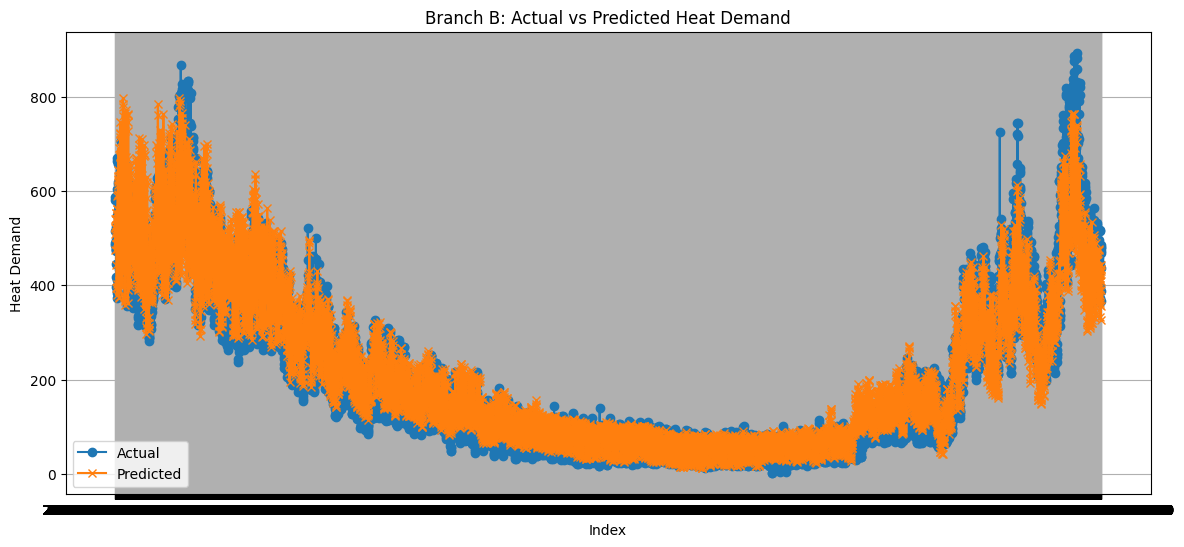

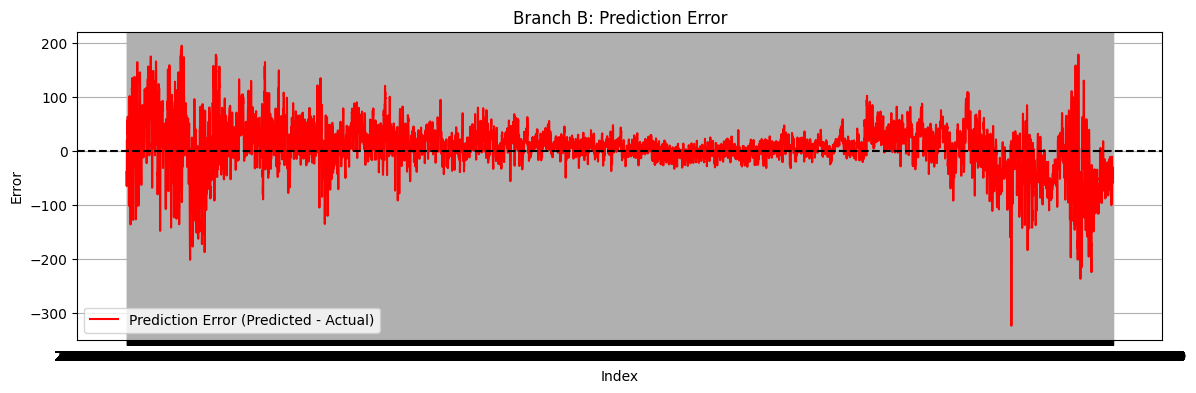

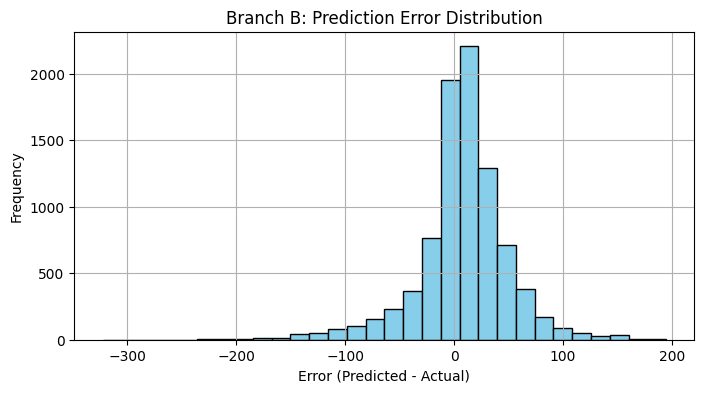

각 Fold의 Validation RMSE: [np.float64(82.70323737770117), np.float64(28.782632818095262)]
최종 평균 Validation RMSE: 55.74293509789822


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 1. branch_id가 'B'인 데이터만 추출
branch = 'B'
train_branch = df_train[df_train['branch_id'] == branch].copy()
test_branch = df_test[df_test['branch_id'] == branch].copy()

# branch_id 컬럼 제거 (모델 입력에 불필요)
train_branch = train_branch.drop(columns=['branch_id'])
test_branch = test_branch.drop(columns=['branch_id'])

target_col = 'heat_demand'

# 2. 예측 수행
results = run_3fold_pipeline_with_residual(train_branch, test_branch, target_col)

# 3. 예측 결과 DataFrame 생성 (index 기준)
test_pred_B = pd.DataFrame({
    'branch_ID': branch,
    'heat_demand': results['test_pred']
}, index=results['test_index'])

# 4. 실제값과 예측값 비교를 위한 df_test_B 준비 (index 기준)
df_test_B = df_test[df_test['branch_id'] == branch].copy()
df_test_B = df_test_B.sort_index()
test_pred_B = test_pred_B.sort_index()

# 5. 공통 인덱스만 사용해서 비교 (NaN 방지)
common_index = df_test_B.index.intersection(test_pred_B.index)
compare_df = df_test_B.loc[common_index, ['heat_demand']].rename(columns={'heat_demand': 'actual'})
compare_df['predicted'] = test_pred_B.loc[common_index, 'heat_demand']
compare_df['diff'] = compare_df['predicted'] - compare_df['actual']

# 6. NaN이 남아있으면 제거
compare_df = compare_df.dropna()

# 7. RMSE, MAE 계산
rmse = np.sqrt(np.mean(compare_df['diff'] ** 2))
mae = np.mean(np.abs(compare_df['diff']))
print(f"Branch B - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# 8. 실제값 vs 예측값 시각화
plt.figure(figsize=(14, 6))
plt.plot(compare_df.index, compare_df['actual'], label='Actual', marker='o')
plt.plot(compare_df.index, compare_df['predicted'], label='Predicted', marker='x')
plt.title('Branch B: Actual vs Predicted Heat Demand')
plt.xlabel('Index')
plt.ylabel('Heat Demand')
plt.legend()
plt.grid(True)
plt.show()

# 9. 오차 시계열 시각화
plt.figure(figsize=(14, 4))
plt.plot(compare_df.index, compare_df['diff'], label='Prediction Error (Predicted - Actual)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Branch B: Prediction Error')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# 10. 오차 분포 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(compare_df['diff'], bins=30, color='skyblue', edgecolor='black')
plt.title('Branch B: Prediction Error Distribution')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("각 Fold의 Validation RMSE:", results['val_rmses'])
print("최종 평균 Validation RMSE:", results['val_rmse'])

In [14]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['actual'],
    mode='lines+markers', name='Actual', marker=dict(symbol='circle', size=5)
))
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['predicted'],
    mode='lines+markers', name='Predicted', marker=dict(symbol='x', size=5)
))
fig.update_layout(
    title='Branch B: Actual vs Predicted Heat Demand',
    xaxis_title='Index',
    yaxis_title='Heat Demand',
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=900, height=400
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['diff'],
    mode='lines+markers', name='Prediction Error', marker=dict(color='red', size=5)
))
fig.add_trace(go.Scatter(
    x=compare_df.index, y=[0]*len(compare_df),  # 0선
    mode='lines', name='Zero Line', line=dict(color='black', dash='dash')
))
fig.update_layout(
    title='Branch B: Prediction Error',
    xaxis_title='Index',
    yaxis_title='Error',
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=900, height=300
)
fig.show()